In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
imp_type

impression type  imp_type_id
0          display            1
1            video            2
2           native            4
3     native video            8
4   rewarded video           16
5              IBV           32
6  rewarded banner           64

In [3]:
xls = pd.ExcelFile('files/Device List.xlsx')
tiers_list = []
for s in ['AT&T','Verizon','Cricket','Tracfone','AMX','ZTE','Xiaomi','Lenovo']:
    sub_df = pd.read_excel(xls, s)[['ELI','Manufacturer', 'Model #','Tier ']]
    tiers_list.append(sub_df)
    
tiers = pd.concat(tiers_list)
tiers

ELI Manufacturer    Model #   Tier 
0             AT&T          ZTE       Z831  Tier 3
1             AT&T           LG       K425  Tier 3
2             AT&T          ZTE        K88  Tier 3
3             AT&T       Huawei      H1611  Tier 3
4             AT&T      Samsung   SM-G891a  Tier 3
..             ...          ...        ...     ...
9           Medion       Lenovo     E1041X      T3
10  Lenovo Tablets       Lenovo    TB-7305      T3
11  Lenovo Tablets       Lenovo    TB-8505      T3
12  Lenovo Tablets       Lenovo  TB-8505FS      T4
13          Medion       Lenovo     E1070X      T3

[718 rows x 4 columns]

In [4]:
tiers = pd.concat(tiers_list)
tiers.rename(columns = {'Tier ':'Tier'}, inplace = True)
tiers['Tier'] = tiers.Tier.str.lower()
tiers['Tier'].replace({'tier':'Tier', 3:'Tier 3', 2:'Tier 2', 1:'Tier 1'}, inplace = True)
tiers['Tier'].unique()

array(['tier 3', 'tier 2', 'tier 1', nan, 'tier 3 - go device', 'tier 3 ',
       't3', 't5', 't4'], dtype=object)

# DoorDash

In [5]:
start_dt = '2021-05-17'
end_dt = '2021-08-17'


In [6]:
dd_campaigns = bigquery_client.query(f"""
select name, uuid from metadata.campaigns 
where lower(name) like '%door%'
""").to_dataframe()

In [7]:
dd_campaign2_list = tuple(dd_campaigns.loc[dd_campaigns.name.str.contains('2'),'uuid'].unique().tolist())
dd_campaign2_list

('25b459301c23a2928eed5b87964e5038', '9c831cedf75097b498cda62c962e18d5')

In [9]:
df_doordash = bigquery_client.query(f"""
with a as 
(
    select 
        tid
        , os
        , osv
        , country
        , carrier
        , min_date 
        , max_date
    from 
    (
        select tid, os, osv, country, carrier, t_created
        , row_number() over (partition by tid order by t_created desc) rn
        , min(t_created) over (partition by tid) as min_date
        , max(t_created) over (partition by tid) as max_date
        from audiences.dt_aud 
        where 
            tid in (select tid from audiences.dt_aud 
                where date(t_created) >= '{start_dt}' and type = 'heartbeat' 
                group by 1)
            and date(t_created) <= '{end_dt}'
            and type = 'heartbeat'
    ) t
    where rn = 1
) 
select
    a.carrier
    , a.os
    , a.osv
    , a.country
    , c.name as campaign_name
    , r.device_model
    , r.device_make
    , a.min_date
    , a.max_date
    , count(*)*1 as installs 
    , sum(revenue)*1 as spend 
    , 0 as d7_first_order
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid
join a
    on r.tid = a.tid
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and event_type = 'install'
    and r.ssb_campaign_uuid in {dd_campaign2_list}
group by 1,2,3,4,5,6,7,8,9

union all

SELECT
    a.carrier
    , a.os
    , a.osv
    , a.country
    , c.name as campaign_name
    , m.device_model
    , m.device_make
    , a.min_date
    , a.max_date
    , 0 as installs 
    , 0 as spend 
    , count(*)*1 as d7_first_order
FROM `apprec-prod.stats.rows1` r
join `apprec-prod.stats.mv_unique3` m
    USING (id)
join a
    on m.tid = a.tid
join metadata.campaigns c
    on m.ssb_campaign_uuid = c.uuid
join (
    select
        etimestamp
        , id
    from stats.rows1 
    where 
        date(etimestamp) >= '{start_dt}'
        and date(etimestamp) <= '{end_dt}'
        and event_type = 'install'
        and ssb_campaign_uuid in {dd_campaign2_list}
) i 
    on r.id = i.id
WHERE
    r.date >= '{start_dt}'-30
    and r.date <= '{end_dt}'
    and extract(date from m.etimestamp) >= '{start_dt}' 
    and extract(date from m.etimestamp) <= '{end_dt}' + 7
    and date_diff(m.etimestamp, i.etimestamp, DAY) <= 7
    and date_diff(m.etimestamp, i.etimestamp, DAY) >= 0
    and r.event_type='pie' 
    and m.ssb_campaign_uuid in {dd_campaign2_list}
    and lower(r.ename) = 'm_firstorder_success'
group by 1,2,3,4,5,6,7,8,9
""").to_dataframe()

df_doordash

carrier       os osv country                        campaign_name  \
0      tracfone  android  10      US     Android-Door Dash-Door Dash-US-2   
1           att  android   9      US     Android-Door Dash-Door Dash-US-2   
2           att  android  10      US     Android-Door Dash-Door Dash-US-2   
3       cricket  android  10      US     Android-Door Dash-Door Dash-US-2   
4       verizon  android  11      US  Android-Door Dash-Door Dash-US-VZ-2   
...         ...      ...  ..     ...                                  ...   
18853  tracfone  android  11      US     Android-Door Dash-Door Dash-US-2   
18854  tracfone  android  11      US     Android-Door Dash-Door Dash-US-2   
18855  tracfone  android  10      US     Android-Door Dash-Door Dash-US-2   
18856  tracfone  android  10      US     Android-Door Dash-Door Dash-US-2   
18857  tracfone  android  11      US     Android-Door Dash-Door Dash-US-2   

                  device_model device_make                  min_date  \
0                       A508DL         TCL 2021-05-14 00:22:43+00:00   
1                     SM-J260A     samsung 2021-04-04 16:42:21+00:00   
2                    SM-A115AP     Samsung 2021-05-25 22:23:55+00:00   
3                        V341U      Vsmart 2021-06-03 00:44:03+00:00   
4                     SM-A115U     Samsung 2020-10-24 21:23:30+00:00   
...                        ...         ...                       ...   
18853  moto g power (XT2041DL)    Motorola 2021-05-11 18:56:00+00:00   
18854  moto g power (XT2041DL)    Motorola 2021-04-19 06:04:10+00:00   
18855  moto g power (XT2041DL)    Motorola 2021-01-31 01:00:02+00:00   
18856  moto g power (XT2041DL)    Motorola 2021-05-10 05:23:18+00:00   
18857  moto g power (XT2041DL)    motorola 2020-09-07 22:11:34+00:00   

                       max_date  installs  spend  d7_first_order  
0     2021-07-13 16:42:16+00:00         0    0.0               1  
1     2021-08-06 19:00:27+00:00         0    0.0               1  
2     2021-05-25 22:23:55+00:00         0    0.0               1  
3     2021-08-13 06:57:18+00:00         0    0.0               2  
4     2021-07-21 12:55:20+00:00         0    0.0               2  
...                         ...       ...    ...             ...  
18853 2021-07-19 07:26:45+00:00         1    1.5               0  
18854 2021-05-26 16:57:39+00:00         1    1.0               0  
18855 2021-08-15 20:56:18+00:00         1    1.5               0  
18856 2021-07-29 17:25:33+00:00         1    3.0               0  
18857 2021-08-01 15:27:10+00:00         1    3.0               0  

[18858 rows x 12 columns]

In [10]:
i = 'os'
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

In [11]:
i = ['os','osv']
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

In [37]:
i = ['campaign_name']
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

In [12]:
i = 'carrier'
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

In [13]:
i = 'country'
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

In [14]:
df_doordash['device_make'] = df_doordash['device_make'].str.lower()
i = 'device_make'
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

In [15]:
i = ['device_make', 'device_model']
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

In [16]:
df_doordash['mindate_weeks'] = round(np.subtract(pd.to_datetime(end_dt).tz_localize('UTC'), df_doordash.min_date)/ np.timedelta64(1, 'W'),0)
df_doordash['maxdate_weeks'] = round(np.subtract(pd.to_datetime(end_dt).tz_localize('UTC'), df_doordash.max_date)/ np.timedelta64(1, 'W'),0)

In [17]:
i = 'maxdate_weeks'
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
# pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

Text(0.5, 0, 'Weeks Before date')

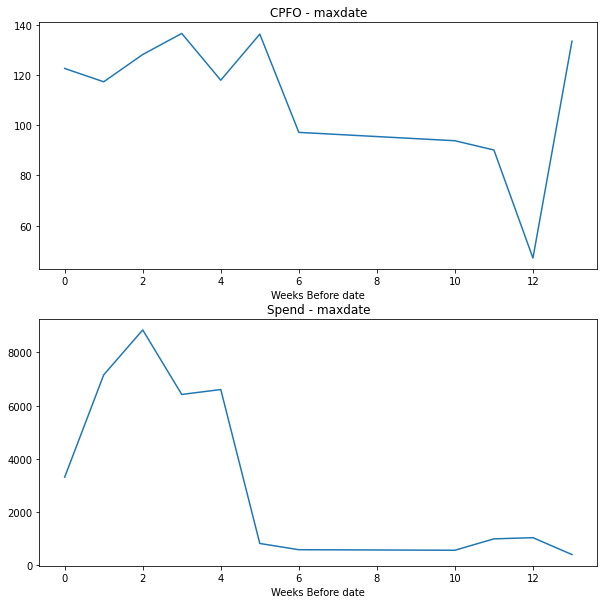

In [18]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
pivot.loc[pivot.spend_sov>1, 'cpfo'].plot(ax = ax[0])
ax[0].set_title('CPFO - maxdate')
ax[0].set_xlabel('Weeks Before date')
pivot.loc[pivot.spend_sov>1, 'spend'].plot(ax = ax[1])
ax[1].set_title('Spend - maxdate')
ax[1].set_xlabel('Weeks Before date')

In [19]:
i = 'mindate_weeks'
pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
pivot['cpfo'] = pivot.spend/pivot.d7_first_order
# pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'order_rate':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'cpfo':'${:,.2f}', 'spend':'${:,.0f}'})

Text(0.5, 0, 'Weeks Before date')

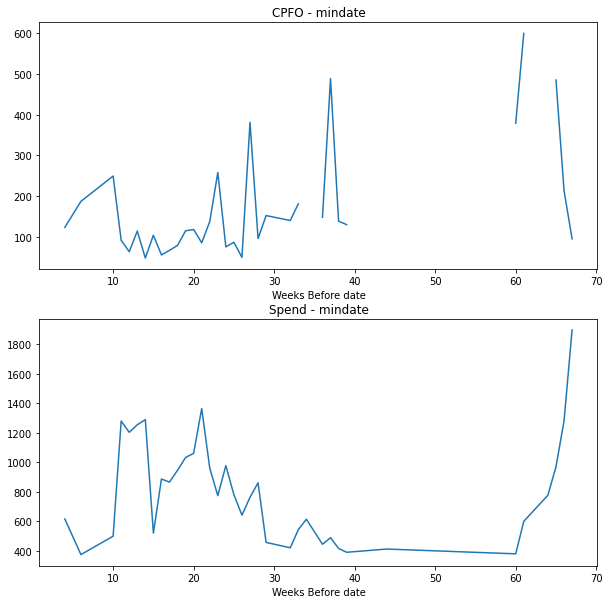

In [20]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
pivot.loc[pivot.spend_sov>1, 'cpfo'].plot(ax = ax[0])
ax[0].set_title('CPFO - mindate')
ax[0].set_xlabel('Weeks Before date')
pivot.loc[pivot.spend_sov>1, 'spend'].plot(ax = ax[1])
ax[1].set_title('Spend - mindate')
ax[1].set_xlabel('Weeks Before date')

In [21]:
with pd.ExcelWriter(f'~/Downloads/DoorDash_audience_opt_{start_dt}_{end_dt}.xlsx') as writer:
    for i in [('os','osv'), 'carrier', 'country', 'device_make', ('device_make','device_model'), 'mindate_weeks','maxdate_weeks']:
        pivot = df_doordash.fillna(-1).pivot_table(values = ['installs','spend','d7_first_order'], index = i, aggfunc = np.sum)
        pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
        pivot['rpi'] = pivot.spend/pivot.installs
        pivot['order_rate'] = (100*pivot.d7_first_order/pivot.installs)
        pivot['cpfo'] = pivot.spend/pivot.d7_first_order
        pivot.sort_values('spend',ascending = False, inplace = True)
        pivot.to_excel(writer, sheet_name=str(i))

# Newsbreak

In [22]:
nb_campaigns = bigquery_client.query(f"""
select name, uuid from metadata.campaigns 
where lower(name) like '%news break%'
or lower(name) like '%newsbreak%'
""").to_dataframe()

In [23]:

nb_campaign2_list = tuple(nb_campaigns.loc[nb_campaigns.name.str.contains('UA'), 'uuid'].unique().tolist())
nb_campaign2_list

('d3a92d5cb2d98df0faf1fe0c47478e21',
 'c40b9831f92edcadd201041150f92c5e',
 '5d294c23d51b0c64a63275f4b8412067',
 'c5534bbfcb4dccdd122f22da877a6f78',
 'fe64a9f1d0e4986d64879d60781f14cf')

In [86]:
df_newsbreak = bigquery_client.query(f"""
with a as 
(
    select 
        tid
        , os
        , osv
        , country
        , carrier
        , min_date 
        , max_date
    from 
    (
        select tid, os, osv, country, carrier, t_created
        , row_number() over (partition by tid order by t_created desc) rn
        , min(t_created) over (partition by tid) as min_date
        , max(t_created) over (partition by tid) as max_date
        from audiences.dt_aud 
        where tid in (select tid from audiences.dt_aud 
                where date(t_created) >= '{start_dt}'-30 and type = 'heartbeat' 
                group by 1)
            and date(t_created) <= '{end_dt}'
            and type = 'heartbeat'
    ) t
    where rn = 1
) 
select
    a.carrier
    , a.os
    , a.osv
    , a.country
    , a.min_date
    , a.max_date
    , count(*)*1 as installs 
    , sum(revenue)*1 as spend 
    , 0 as d1_open
from stats.rows1 r
join a
    on r.tid = a.tid
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and event_type = 'install'
    and r.ssb_campaign_uuid in {nb_campaign2_list}
group by 1,2,3,4,5,6

union all

SELECT
    a.carrier
    , a.os
    , a.osv
    , a.country
    , a.min_date
    , a.max_date
    , 0 as installs 
    , 0 as spend 
    , count(distinct i.tid)*1 as d1_open
FROM `apprec-prod.stats.pies` r
join (
    select
        etimestamp
        , id
        , tid
    from stats.rows1 
    where 
        date(etimestamp) >= '{start_dt}'
        and date(etimestamp) <= '{end_dt}'
        and event_type = 'install'
        and ssb_campaign_uuid in {nb_campaign2_list}
) i 
    on r.id = i.id
join a
    on i.tid = a.tid
WHERE
    r.date >= '{start_dt}' - 30
    and r.date <= '{end_dt}'
    and extract(date from r.etimestamp) >= '{start_dt}' 
    and extract(date from r.etimestamp) <= '{end_dt}' + 1
    and date_diff(date(r.etimestamp), date(i.etimestamp), DAY) = 1
    and r.event_type='pie' 
    and r.ssb_campaign_uuid in {nb_campaign2_list}
    and lower(r.ename) = 'af_app_opened'
group by 1,2,3,4,5,6
""").to_dataframe()

df_newsbreak

carrier       os     osv country                  min_date  \
0          samsung  android      10      US 2021-05-24 19:41:16+00:00   
1          samsung  android      10      US 2020-08-27 20:00:21+00:00   
2          samsung  android      10      US 2020-08-13 22:45:41+00:00   
3          samsung  android      10      US 2021-07-05 19:43:40+00:00   
4          samsung  android  10.0.0      US 2020-08-16 19:19:55+00:00   
...            ...      ...     ...     ...                       ...   
273201  uscellular  android   8.1.0      US 2021-07-23 23:58:28+00:00   
273202  uscellular  android      11      US 2020-06-08 21:18:32+00:00   
273203  uscellular  android   8.0.0      US 2020-09-15 12:49:33+00:00   
273204  uscellular  android       9      US 2020-05-13 08:19:00+00:00   
273205  uscellular  android       9      US 2020-06-10 19:35:09+00:00   

                        max_date  installs  spend  d1_open  
0      2021-05-24 19:56:33+00:00         0   0.00        1  
1      2021-07-08 17:41:35+00:00         0   0.00        1  
2      2021-07-22 02:28:32+00:00         0   0.00        1  
3      2021-07-05 19:55:51+00:00         0   0.00        1  
4      2021-06-26 07:22:59+00:00         0   0.00        1  
...                          ...       ...    ...      ...  
273201 2021-07-24 00:00:24+00:00         1   2.25        0  
273202 2021-08-08 21:59:07+00:00         1   2.25        0  
273203 2021-08-05 12:27:56+00:00         1   2.25        0  
273204 2021-07-27 01:47:20+00:00         2   4.50        0  
273205 2021-08-03 20:24:12+00:00         1   2.25        0  

[273206 rows x 9 columns]

In [87]:
i = 'os'
pivot = df_newsbreak.fillna(-1).pivot_table(values = ['installs','spend','d1_open'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['d1_rr'] = (100*pivot.d1_open/pivot.installs)
pivot['d1_cpr'] = pivot.spend/pivot.d1_open
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'d1_rr':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'd1_cpr':'${:,.2f}', 'spend':'${:,.0f}'})

In [88]:
i = ['os','osv']
pivot = df_newsbreak.fillna(-1).pivot_table(values = ['installs','spend','d1_open'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['d1_rr'] = (100*pivot.d1_open/pivot.installs)
pivot['d1_cpr'] = pivot.spend/pivot.d1_open
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'d1_rr':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'd1_cpr':'${:,.2f}', 'spend':'${:,.0f}'})

In [89]:
i = ['carrier']
pivot = df_newsbreak.fillna(-1).pivot_table(values = ['installs','spend','d1_open'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['d1_rr'] = (100*pivot.d1_open/pivot.installs)
pivot['d1_cpr'] = pivot.spend/pivot.d1_open
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'d1_rr':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'd1_cpr':'${:,.2f}', 'spend':'${:,.0f}'})

In [90]:
i = ['country']
pivot = df_newsbreak.fillna(-1).pivot_table(values = ['installs','spend','d1_open'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['d1_rr'] = (100*pivot.d1_open/pivot.installs)
pivot['d1_cpr'] = pivot.spend/pivot.d1_open
pivot.sort_values('spend',ascending = False, inplace = True)
pivot.style.format({'d1_rr':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'd1_cpr':'${:,.2f}', 'spend':'${:,.0f}'})

In [91]:
df_newsbreak['mindate_weeks'] = round(np.subtract(pd.to_datetime(end_dt).tz_localize('UTC'), df_newsbreak.min_date)/ np.timedelta64(1, 'W'),0)
df_newsbreak['maxdate_weeks'] = round(np.subtract(pd.to_datetime(end_dt).tz_localize('UTC'), df_newsbreak.max_date)/ np.timedelta64(1, 'W'),0)

In [92]:
i = ['mindate_weeks']
pivot = df_newsbreak.fillna(-1).pivot_table(values = ['installs','spend','d1_open'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['d1_rr'] = (100*pivot.d1_open/pivot.installs)
pivot['d1_cpr'] = pivot.spend/pivot.d1_open
pivot.style.format({'d1_rr':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'd1_cpr':'${:,.2f}', 'spend':'${:,.0f}'})

Text(0.5, 0, 'Weeks Before')

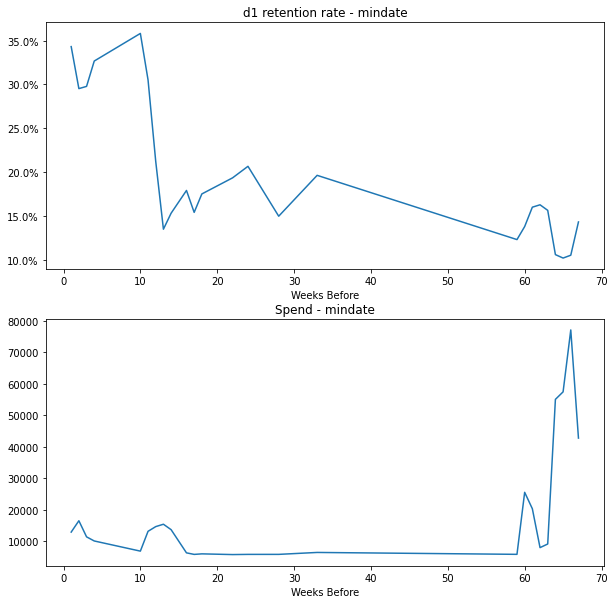

In [93]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
pivot.loc[pivot.spend_sov>1, 'd1_rr'].plot(ax = ax[0])
ax[0].set_title('d1 retention rate - mindate')
ax[0].set_xlabel('Weeks Before')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
pivot.loc[pivot.spend_sov>1, 'spend'].plot(ax = ax[1])
ax[1].set_title('Spend - mindate')
ax[1].set_xlabel('Weeks Before')

In [94]:
i = ['maxdate_weeks']
pivot = df_newsbreak.fillna(-1).pivot_table(values = ['installs','spend','d1_open'], index = i, aggfunc = np.sum)
pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
pivot['rpi'] = pivot.spend/pivot.installs
pivot['d1_rr'] = (100*pivot.d1_open/pivot.installs)
pivot['d1_cpr'] = pivot.spend/pivot.d1_open
pivot.style.format({'d1_rr':'{:,.1f}%','spend_sov':'{:,.0f}%', 'rpi':'${:,.2f}', 'd1_cpr':'${:,.2f}', 'spend':'${:,.0f}'})

Text(0.5, 0, 'Weeks Before')

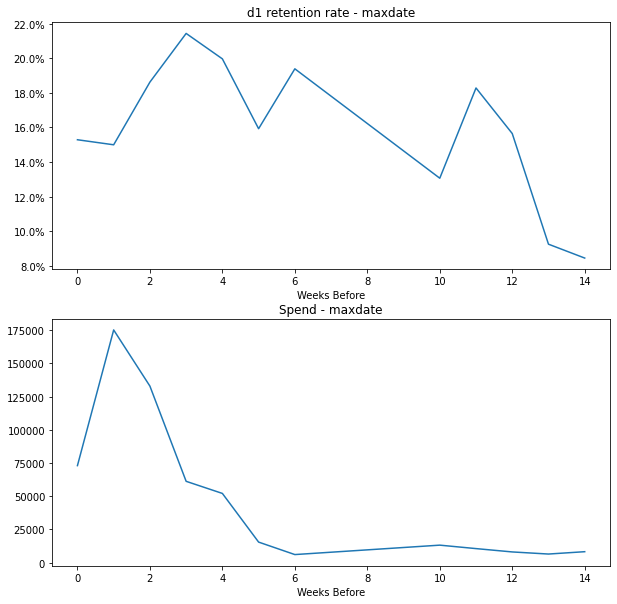

In [95]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
pivot.loc[pivot.spend_sov>1, 'd1_rr'].plot(ax = ax[0])
ax[0].set_title('d1 retention rate - maxdate')
ax[0].set_xlabel('Weeks Before')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
pivot.loc[pivot.spend_sov>1, 'spend'].plot(ax = ax[1])
ax[1].set_title('Spend - maxdate')
ax[1].set_xlabel('Weeks Before')

In [70]:
with pd.ExcelWriter(f'~/Downloads/Newsbreak_audience_opt_{start_dt}_{end_dt}.xlsx') as writer:
    for i in [('os','osv'), 'carrier', 'country', 'device_make', ('device_make','device_model'), 'mindate_weeks','maxdate_weeks']:
        pivot = df_newsbreak.fillna(-1).pivot_table(values = ['installs','spend','d1_open'], index = i, aggfunc = np.sum)
        pivot['spend_sov'] = 100*pivot.spend/pivot.spend.sum()
        pivot['rpi'] = pivot.spend/pivot.installs
        pivot['d1_rr'] = (100*pivot.d1_open/pivot.installs)
        pivot['d1_cpr'] = pivot.spend/pivot.d1_open
        pivot.sort_values('spend',ascending = False, inplace = True)
        pivot.to_excel(writer, sheet_name=str(i))